# Abstract
This notebook tests the slab ocean model (SOM) that is integrated in Speedy. SOM is not an independent component but rather lives as part of the `boundary`. 

## TODO:
- Test a coupled case.

## Questions:

- How does JAX handle NaN.
- What are the fluxes of fluxn[:, :, :, 0] and hfluxn[:, :, :, 1]?

In [1]:
from dinosaur import primitive_equations_states

import jax.tree_util as jtu
import pandas as pd

from jcm.params import Parameters
from jcm.physics_data import PhysicsData
from jcm.model import SpeedyModel

import jax.numpy as jnp
import numpy as np

In [2]:
print("Building SpeedyModel...")
layers = 8
# optionally add a boundary conditions file
model = SpeedyModel(
    time_step=24*60,  # minutes
    save_interval=1,  # day
    total_time=1,     # day
    layers=layers,
    parameters=Parameters.default(),
    boundaries = "Tien-Yiao_test",
)
print("Done.")

lon = np.array(model.coords.horizontal.longitudes) * 180/np.pi
lat = np.array(model.coords.horizontal.latitudes) * 180/np.pi
print("lon.shape: ", lon.shape)
print("lat.shape: ", lat.shape)




Building SpeedyModel...
I am here?
Called: slabocean_model_init
time_step =  1440 minute
time_step in seconds =  86400
sst_init: 
mean:  282.91998
[[      nan       nan       nan ... 263.34967 249.55959 246.71623]
 [      nan       nan       nan ... 267.46823 250.08994 246.82742]
 [      nan       nan       nan ... 268.28647 250.54623 246.93295]
 ...
 [      nan       nan       nan ... 251.9501  248.0587  246.2676 ]
 [      nan       nan       nan ... 253.55649 248.40138 246.4164 ]
 [      nan       nan       nan ... 257.6736  248.94328 246.5694 ]]
Done.
lon.shape:  (96,)
lat.shape:  (48,)


## Check Initial SST

Max value of sst_init:  9.96921e+36


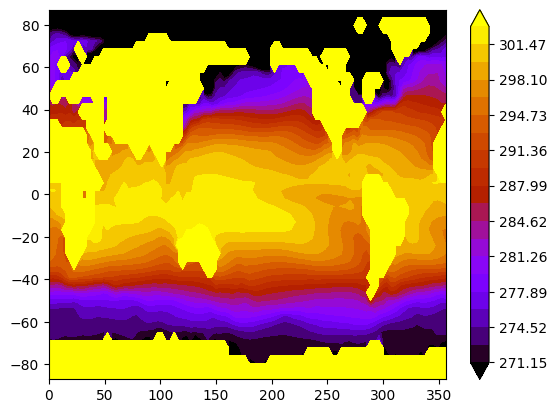

In [3]:
sst_init = np.array(model.boundaries.sst)
maxval = np.amax(sst_init)
print("Max value of sst_init: ", maxval)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
mappable = ax.contourf(lon, lat, sst_init.T, np.linspace(-2, 30, 20) + 273.15, cmap="gnuplot", extend="both")

plt.colorbar(mappable, ax=ax)

plt.show()

In [4]:
state = model.get_initial_state()

# Specify humidity perturbation in kg/kg
state.tracers = {'specific_humidity': 1e-2 * primitive_equations_states.gaussian_scalar(model.coords, model.physics_specs)}

modal_zxy, nodal_zxy = model.coords.modal_shape, model.coords.nodal_shape
nodal_tzxy = (model.outer_steps,) + nodal_zxy

final_state, predictions = model.unroll(state)

Called: couple_sea_atm


In [5]:
dyn_pred = predictions['dynamics']
phy_pred = predictions['physics']

In [6]:
print("Listing shapes: ")
for i, varname in enumerate(["u_wind", "temperature"]):
    v = getattr(dyn_pred, "u_wind")
    print(f"<{i+1:d}> Shape of var {varname:s}: ", v.shape)


Listing shapes: 
<1> Shape of var u_wind:  (1, 8, 96, 48)
<2> Shape of var temperature:  (1, 8, 96, 48)


In [18]:
sst = np.array(phy_pred.slabocean_model.sst)
hfluxn = np.array(phy_pred.surface_flux.hfluxn)
print("sst.shape: ", sst.shape)
print("hfluxn.shape: ", hfluxn.shape)

print(sst)
print(hfluxn)

sst.shape:  (1, 96, 48)
hfluxn.shape:  (1, 96, 48, 2)
[[[9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.5765671e+02
   2.4388162e+02 2.4104329e+02]
  [9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.6177515e+02
   2.4441194e+02 2.4115450e+02]
  [9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.6259329e+02
   2.4486826e+02 2.4126003e+02]
  ...
  [9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.4625674e+02
   2.4238074e+02 2.4059464e+02]
  [9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.4786322e+02
   2.4272345e+02 2.4074344e+02]
  [9.9692100e+36 9.9692100e+36 9.9692100e+36 ... 2.5198058e+02
   2.4326535e+02 2.4089645e+02]]]
[[[[-25.366455  63.25872 ]
   [-25.457458  63.258774]
   [-25.470062  63.25854 ]
   ...
   [-30.96167   63.258354]
   [-30.961884  63.258934]
   [-30.96167   63.258793]]

  [[-25.36261   63.258717]
   [-25.42691   63.258774]
   [-25.432678  63.258545]
   ...
   [-30.96167   63.258312]
   [-30.961884  63.258934]
   [-30.96167   63.2588  ]]

  [[-25.359192  63.258717]

## Check output


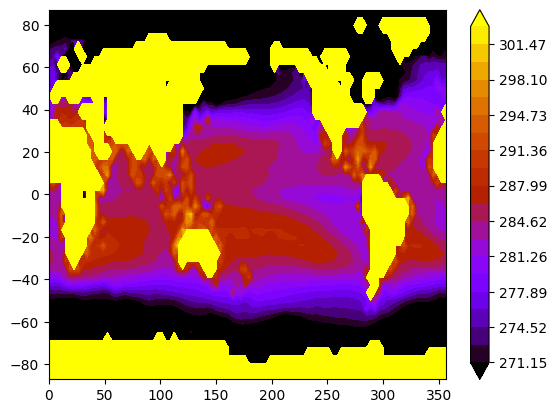

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
mappable = ax.contourf(lon, lat, sst[0].T, np.linspace(-2, 30, 20) + 273.15, cmap="gnuplot", extend="both")

plt.colorbar(mappable, ax=ax)

plt.show()

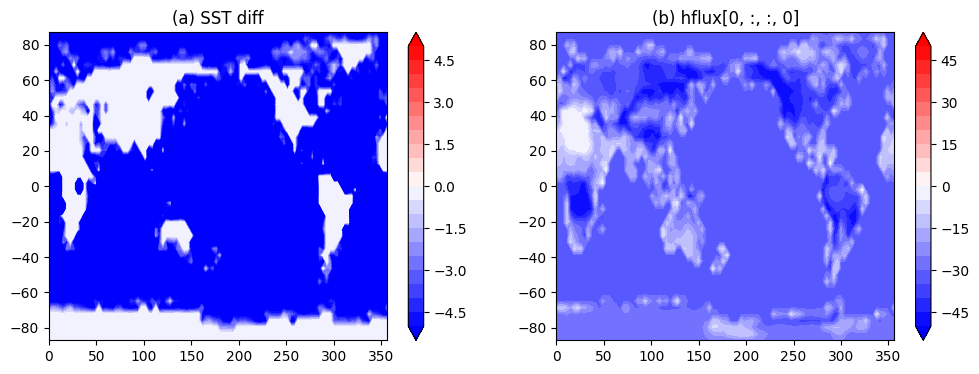

In [23]:
# Check the difference

sst_diff = sst[0, :, :] - sst_init
hfluxn_plot = hfluxn[0, :, :, 0]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# SST change
mappable = ax[0].contourf(lon, lat, sst_diff.T, np.linspace(-1, 1, 21) * 5, cmap="bwr", extend="both")
plt.colorbar(mappable, ax=ax[0])

# SST change
mappable = ax[1].contourf(lon, lat, hfluxn_plot.T, np.linspace(-1, 1, 21) * 50, cmap="bwr", extend="both")
plt.colorbar(mappable, ax=ax[1])


ax[0].set_title("(a) SST diff")
ax[1].set_title("(b) hflux[0, :, :, 0]")

plt.show()
